In [26]:
import numpy as np 
import cv2
import glob
import os
import matplotlib.pyplot as plt
import pickle
import random
import string
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from sklearn.svm import SVC

In [27]:
pick_in=open('projdata1.pickle','rb')
data=pickle.load(pick_in)
pick_in.close()

In [5]:
random.shuffle(data)
features=[]
labels=[]

for feature, label in data:
    features.append(feature)
    labels.append(label)
    
print(type(features))
print(type(labels))
print(len(features))
m = np.asarray(features)
print(m.shape)
m = m.astype(np.float64)
m -= m.mean()
print(type(m))
print(m.ndim)

<class 'list'>
<class 'list'>
3600
(3600, 2500)
<class 'numpy.ndarray'>
2


In [6]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn import decomposition

In [7]:
def shrink(X,tau):
    Y = np.abs(X)-tau
    return np.sign(X) * np.maximum(Y,np.zeros_like(Y))
def SVT(X,tau):
    U,S,VT = np.linalg.svd(X,full_matrices=0)
    out = U @ np.diag(shrink(S,tau)) @ VT
    return out
def RPCA(X):
    n1,n2 = X.shape
    mu = n1*n2/(4*np.sum(np.abs(X.reshape(-1))))
    lambd = 1/np.sqrt(np.maximum(n1,n2))
    thresh = 10**(-7) * np.linalg.norm(X)
    
    S = np.zeros_like(X)
    Y = np.zeros_like(X)
    L = np.zeros_like(X)
    count = 0
    while (np.linalg.norm(X-L-S) > thresh) and (count < 1000):
        L = SVT(X-S+(1/mu)*Y,1/mu)
        S = shrink(X-L+(1/mu)*Y,lambd/mu)
        Y = Y + mu*(X-L-S)
        count += 1
    return L,S

In [8]:
L,S = RPCA(m)

In [9]:
print(L.shape)

(3600, 2500)


In [10]:
pick_in=open('projlowrdat1.pickle','wb')
pickle.dump(L,pick_in)
pick_in.close()

In [11]:
pick_in=open('projspardat1.pickle','wb')
pickle.dump(S,pick_in)
pick_in.close()

In [25]:
pick_in=open('projlowrdat1.pickle','rb')
lowr=pickle.load(pick_in)
pick_in.close()

In [15]:
print(type(L))
list1 = L.tolist()
print(type(list1))
print(len(list1))

<class 'numpy.ndarray'>
<class 'list'>
3600


In [13]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import decomposition
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [16]:
xtrain, xtest, ytrain, ytest=train_test_split(list1,labels, test_size=0.25)

In [17]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000], #Regularization parameter
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10] #number of trees in the forest
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(penalty='l1',solver='saga',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10] #regularization 
        }
    }
}

In [18]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(xtrain, ytrain)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

,model,best_score,best_params
0,svm,0.952963,"{'svc__C': 10, 'svc__kernel': 'rbf'}"
1,random_forest,0.885556,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.927778,{'logisticregression__C': 1}


In [20]:
best_estimators['svm'].score(xtest,ytest)

0.9577777777777777

In [21]:
best_estimators['random_forest'].score(xtest,ytest)

0.9144444444444444

In [22]:
best_estimators['logistic_regression'].score(xtest,ytest)

0.93

In [23]:
from sklearn.metrics import confusion_matrix
best_clf = best_estimators['svm']
cm = confusion_matrix(ytest, best_clf.predict(xtest))
cm

array([[278,   3,   4],
       [  2, 290,  12],
       [  4,  13, 294]], dtype=int64)

Text(69.0, 0.5, 'Truth')

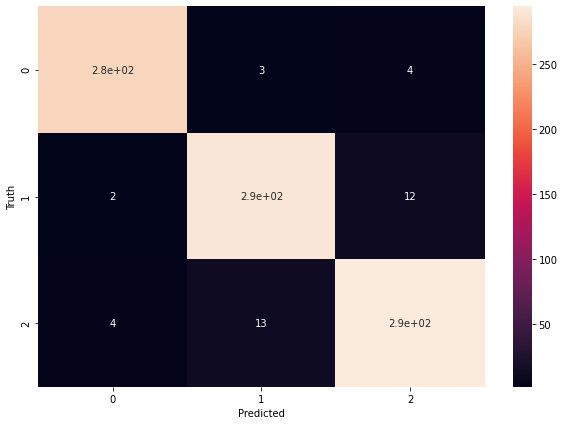

In [24]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')